**1. Basic Plotting**

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch #for plotting custom legend
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import xarray as xr #for reading nc files
import numpy as np
from skimage.measure import block_reduce #for downsampling the grid

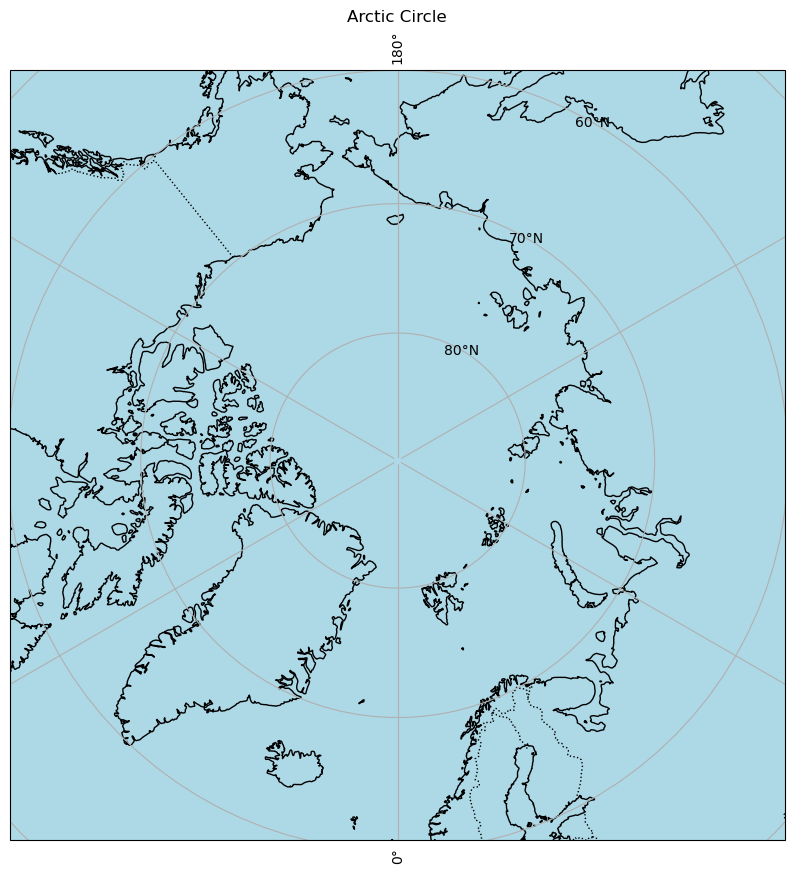

In [67]:
#set up the plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())  #focus on the Arctic area

#add land and ocean features
ax.add_feature(cfeature.LAND, color='lightgrey')
ax.add_feature(cfeature.OCEAN, color='lightblue')
ax.add_feature(cfeature.COASTLINE)

#add borders and gridlines
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True)

#plot title and show map
plt.title("Arctic Circle")
plt.show()

**2. Energy Resource Potential**

https://arctic-nga.opendata.arcgis.com/maps/dae204a1fdb34a4986f59fe8a5adc6c6/about

In [6]:
#load and project the GeoJSON data
energypotential = gpd.read_file("Energy_Resources_Potential_-586856091372141632.geojson")
energypotential = energypotential.to_crs("EPSG:3995")

In [7]:
energypotential.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   OBJECTID     73 non-null     int32   
 1   REG_NUM      73 non-null     object  
 2   REG_NAME     73 non-null     object  
 3   PROVCODE     73 non-null     object  
 4   PROV_NAME    73 non-null     object  
 5   ASSESSCODE   73 non-null     object  
 6   ASSESSNAME   73 non-null     object  
 7   Probability  64 non-null     object  
 8   geometry     73 non-null     geometry
dtypes: geometry(1), int32(1), object(7)
memory usage: 5.0+ KB


In [8]:
#drop null values in Probability column
energypotential_cleaned = energypotential.dropna(subset='Probability')

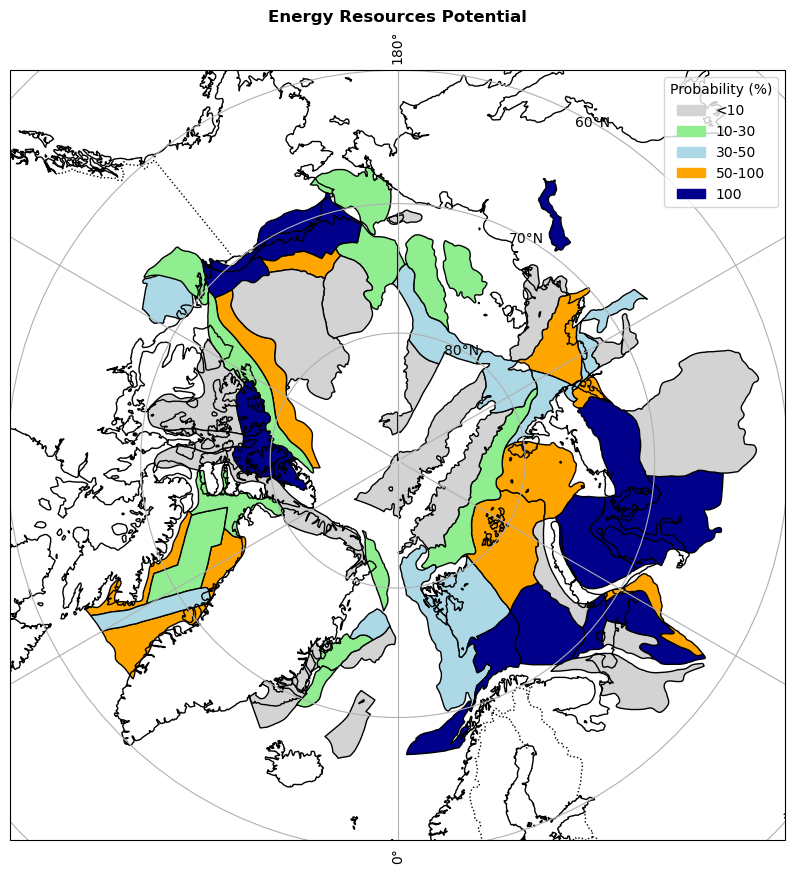

In [71]:
#set up the Arctic map plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())

#add base map features
ax.add_feature(cfeature.LAND, color='lightgrey')
ax.add_feature(cfeature.OCEAN, color='white')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True)

#define color map for categorical values
category_colors = {
    '<10': 'lightgrey',
    '10-30': 'lightgreen',
    '30-50': 'lightblue',
    '50-100': 'orange',
    '100': 'darkblue'
}

#create a copy of the DataFrame to avoid modifying the original DataFrame
energypotential_cleaned_copy = energypotential_cleaned.copy()

#map 'Probability' column to corresponding colors using .loc
energypotential_cleaned_copy.loc[:, 'color'] = energypotential_cleaned_copy['Probability'].map(category_colors)

#plot the energy potential layer with the mapped colors
energypotential_cleaned_copy.plot(ax=ax, color=energypotential_cleaned_copy['color'], edgecolor='black')

#create a custom legend
legend_patches = [Patch(color=color, label=label) for label, color in category_colors.items()]
plt.legend(handles=legend_patches, title="Probability (%)", loc='upper right')

#plot title and show map
plt.title("Energy Resources Potential", fontweight = "bold")

#save the image
plt.savefig("energy_resources_potential.png", dpi=300, bbox_inches="tight")

#show the image
plt.show()

**3. Gridded Bathymetry Data**

https://www.gebco.net/data_and_products/gridded_bathymetry_data/#area

In [11]:
#read file
nc_file = "GEBCO_2024_sub_ice_topo.nc"
ds = xr.open_dataset(nc_file)

In [12]:
#extract the latitude, longitude, and elevation (bathymetry) data
lon = ds['lon'].values
lat = ds['lat'].values
elevation = ds['elevation'].values

In [82]:
#define the latitude and longitude bounds for the Arctic region
lat_min, lat_max = 60, 90
lon_min, lon_max = -180, 180

#clip the latitude and longitude arrays
lat_idx = np.where((lat >= lat_min) & (lat <= lat_max))[0]
lon_idx = np.where((lon >= lon_min) & (lon <= lon_max))[0]

#slice the elevation data to the Arctic region
elevation_arctic = elevation[lat_idx[:, None], lon_idx] 

#slice the longitude and latitude arrays to the selected region
lat_arctic = lat[lat_idx]
lon_arctic = lon[lon_idx]

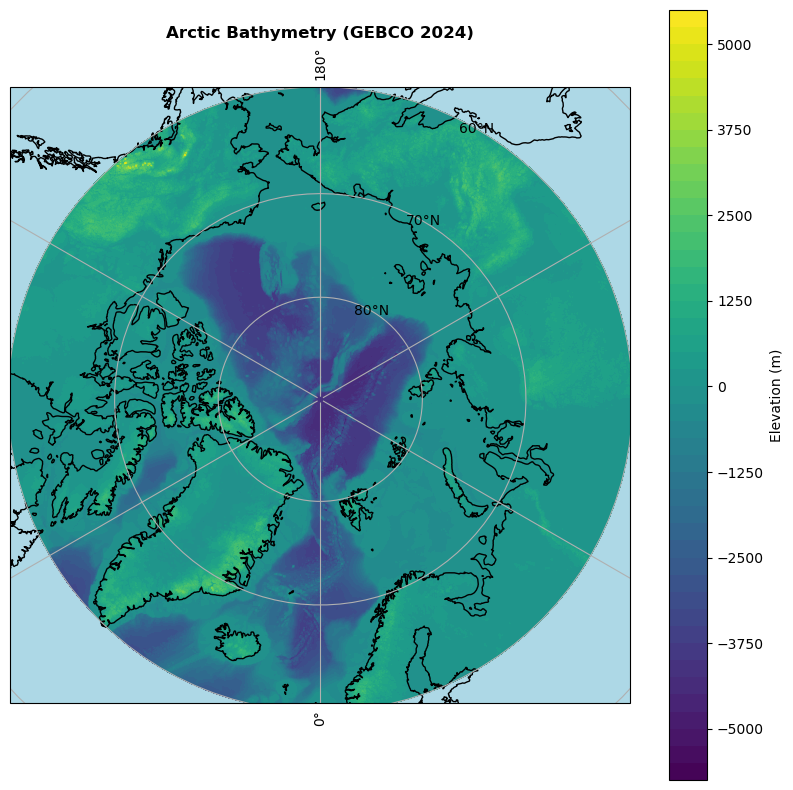

In [84]:
#downscale by a factor (by a factor of 10)
downsampled_elevation = block_reduce(elevation_arctic, block_size=(10, 10), func=np.mean)

#create a meshgrid for the downsampled data
downsampled_lon, downsampled_lat = np.meshgrid(lon_arctic[::10], lat_arctic[::10])

#plot the downsampled data
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, color='lightgrey')
ax.add_feature(cfeature.OCEAN, color='lightblue')
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(draw_labels=True)

cp = ax.contourf(downsampled_lon, downsampled_lat, downsampled_elevation, 50, cmap='viridis', transform=ccrs.PlateCarree())
fig.colorbar(cp, ax=ax, label='Elevation (m)')
plt.title("Arctic Bathymetry (GEBCO 2024)", fontweight = "bold")

#save the image
plt.savefig("arctic_bathymetry.png", dpi=300, bbox_inches="tight")

#show the image
plt.show()

**Notes**

ccrs.NorthPolarStereo() is the projection for the map itself. This is the coordinate reference system (CRS) that Cartopy will use to transform the data when plotting the map. The North Polar Stereographic projection is ideal for showing polar regions like the Arctic, as it focuses on the area near the North Pole.

crs=ccrs.PlateCarree() is the coordinate system for the extent you are defining. The Plate Carree projection is often used for specifying boundaries, as it assumes a simple longitude-latitude grid (i.e., a geographic projection). In this case, you’re telling Cartopy to interpret the extent of the plot in terms of geographic coordinates (longitude, latitude) before the map is transformed into the Arctic projection for rendering.